In [17]:
import gym
import load_policy
from keras.models import Sequential
from keras.layers import Dense
import keras
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
%matplotlib inline

In [18]:
args = ({ 
    'epochs': 50, 
    'render' : False,  
    'timesteps_max' : 300,
    'env':'Hopper-v2',  
    'size_batch': 128,
    'rollouts' : 5,
    'expert_policy_pickle_file' : 'experts/Hopper-v2.pkl'
})

# Generate plt
#def plot_create(x,y,title):
 #   fig, ax = plt.subplots( nrows=1, ncols=1 )
 #   ax.set_xlabel(x)
 #   ax.set_ylabel(y)
 #   ax.set_title(title)    
 #   return ax


In [19]:
class Environment:
    
    def run_policy(self, agent, max_steps, render,rollouts):
        with self.session.as_default():
            returns = []
            observations = []
            actions = []
            for i in range(rollouts):
                obs = self.env.reset()
                cumulative_reward = 0
                steps = 0
                gameover = False
                
                while not gameover:
                    action = agent.action(obs)
                    observations.append(obs)
                    actions.append(np.squeeze(action))
                    obs, reward, gameover, _ = self.env.step(action)
                    cumulative_reward += reward
                    steps += 1
                    if render:
                        self.env.render()
                        
                    if steps >= max_steps:
                        break
                if steps < max_steps:
                    print('\tGame over at step %i' % steps)
                
                print('\tGame simulation %i/%i return=%f' % (i+1, rollouts, cumulative_reward))
                returns.append(cumulative_reward)
            
            print('Return summary: mean=%f, std=%f' % (np.mean(returns), np.std(returns)))
            agent.store_reward(returns)
            return [np.array(observations), np.array(actions)]
    
    
    def get_total_reward(self, agent, max_steps, render):
        with self.session.as_default():
            obs = self.env.reset()
            cumulative_reward = 0
            steps = 0
            gameover = False
                
            while not gameover:
                action = agent.action(obs)
                obs, reward, gameover, _ = self.env.step(action)
                cumulative_reward += reward
                steps += 1
                if render:
                    self.env.render()
                        
                if steps >= max_steps:
                    break
            return cumulative_reward
            
    def __init__(self, envname):
        self.init(envname)
        self.envname = envname
        
    def init(self, envname):
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        self.env = gym.make(envname)
    
    def reset(self):
        self.session.close()
        self.init(self.envname)
        
    def label_obs(self, exp, obs):
        with self.session.as_default():
            return exp.policy_fn(obs)
        

class Agent:
    def __init__(self, data_dim):
        self.model = Sequential();
        self.model.add(Dense(80, input_dim=data_dim[0], activation='relu', kernel_initializer = 'glorot_normal'))
        self.model.add(Dense(40, activation = 'relu', kernel_initializer = 'glorot_normal'))
        self.model.add(Dense(units=data_dim[1]))
        self.model.compile(loss='mse', optimizer='adam')
        self.history = []
        self.rewards = []

    def action(self, obs):
        X = np.expand_dims(obs, 0)
        return self.model.predict(X, batch_size=200, verbose=0)
    
    def store_reward(self, reward):
        self.rewards.append(np.mean(reward))
    
    def train(self, training_data, size_batch, epochs):
        history = self.model.fit(training_data[0], training_data[1], size_batch, epochs, 0)
        self.history.append(np.mean(history.history['loss']))

class Expert:
    def __init__(self, expert_policy_pickle_file):
        self.policy_fn = load_policy.load_policy(expert_policy_pickle_file)

    def store_reward(self, reward):
        pass
    
    def action(self, obs):
        return self.policy_fn(obs[None,:])
    
    




In [20]:
expert = Expert(args['expert_policy_pickle_file'])

obs (1, 11) (1, 11)


In [21]:
# Generate training data
environment = Environment(args['env'])
training_data = environment.run_policy(expert, max_steps=args['timesteps_max'],  render=False, rollouts=args['rollouts'])

/Users/smithshah/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
	Game simulation 1/5 return=993.836756
	Game simulation 2/5 return=990.741176
	Game simulation 3/5 return=992.627387
	Game simulation 4/5 return=988.987943
	Game simulation 5/5 return=995.822240
Return summary: mean=992.403101, std=2.375773


In [22]:
data_dim = (training_data[0].shape[-1], training_data[1].shape[-1])
dagger = Agent(data_dim)
dagger.train(training_data, size_batch=args['size_batch'], epochs=args['epochs'])
#print(training_data[1])

In [23]:
# Train DAgger Agent
beta = 0.95
environment.reset()
tdata = [training_data[0],training_data[1]]
for i in range(2, 11):
    print("Train with DAgger, iter %i" % i)
    beta = 0.95**(i-1)
    [env_obs, agent_labels] = environment.run_policy(dagger, max_steps=args['timesteps_max'], render=False, rollouts=args['rollouts'])
    labels = environment.label_obs(expert, env_obs)
    tdata[0]=np.concatenate((tdata[0],env_obs))
    tdata[1]=np.concatenate((tdata[1],beta*labels + (1-beta)*agent_labels))
    with environment.session.as_default():
        dagger.train(tdata, size_batch=args['size_batch'], epochs=args['epochs'])

/Users/smithshah/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Train with DAgger, iter 2
	Game over at step 163
	Game simulation 1/5 return=275.863584
	Game over at step 161
	Game simulation 2/5 return=274.157373
	Game over at step 163
	Game simulation 3/5 return=276.649947
	Game over at step 158
	Game simulation 4/5 return=271.339470
	Game over at step 153
	Game simulation 5/5 return=265.566909
Return summary: mean=272.715457, std=4.011611
Train with DAgger, iter 3
	Game over at step 229
	Game simulation 1/5 return=687.807421
	Game over at step 231
	Game simulation 2/5 return=702.148807
	Game over at step 232
	Game simulation 3/5 return=703.804828
	Game over at step 233
	Game simulation 4/5 return=709.209237
	Game over at step 229
	Game simulation 5/5 return=688.619362
Return summary: mean=698.317931, std=8.578289
Train with DAgger, iter 4
	Game simula

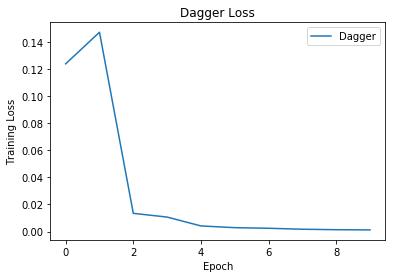

In [24]:
plt.plot(dagger.history,label='Dagger')
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.title('Dagger Loss')
plt.legend()
plt.show()

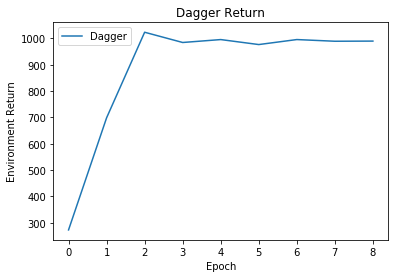

In [25]:
plt.plot(dagger.rewards,label='Dagger')
plt.ylabel('Environment Return')
plt.xlabel('Epoch')
plt.title('Dagger Return')
plt.legend()
plt.show()

In [26]:
expertreward = environment.get_total_reward(expert, 10000, render=False)
agentreward = environment.get_total_reward(dagger, 10000, render=False)

In [27]:
print(expertreward)
print(agentreward)

3778.8426340478786
3535.5050800192403
